$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [118]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [119]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/tal.yaakov/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [120]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


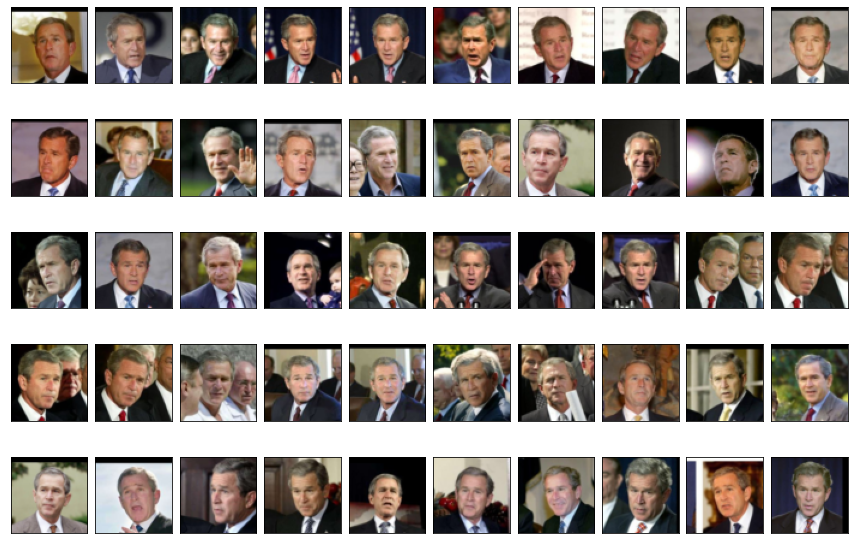

In [121]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [122]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [123]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (classifier_extractor): Sequential(
    (0): Linear(in_features=4096, out_features=4, bias=True)
    (1): LeakyReLU(negati

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [124]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [125]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [126]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

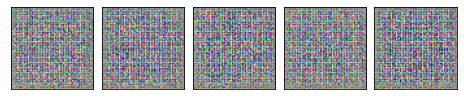

In [127]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [128]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.9037216305732727
Generator loss:     0.9538207529317622
Saved checkpoint.


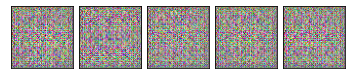

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 0.43216846386591595
Generator loss:     1.7228957434895584
Saved checkpoint.


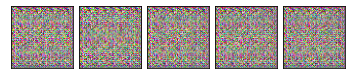

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 0.3180139677392112
Generator loss:     2.3586695935352764
Saved checkpoint.


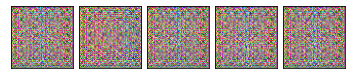

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.2892712636126412
Generator loss:     2.7041946677962443
Saved checkpoint.


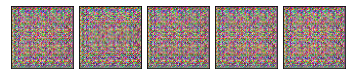

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: 0.277477224667867
Generator loss:     3.037823169987242
Saved checkpoint.


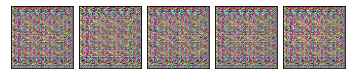

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 0.23498411145475176
Generator loss:     3.3802327893395168
Saved checkpoint.


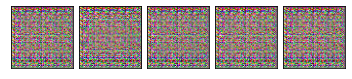

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 0.22233315888378355
Generator loss:     3.4079452499011804
Saved checkpoint.


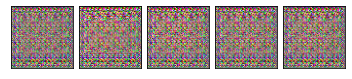

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.22292420268058777
Generator loss:     3.510237535707132
Saved checkpoint.


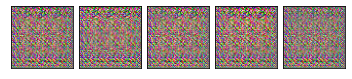

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.1687768515613344
Generator loss:     3.4641815159711324
Saved checkpoint.


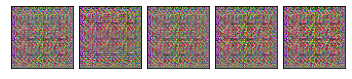

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 0.2338375738925404
Generator loss:     3.578619318952378
Saved checkpoint.


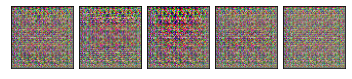

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 0.2249064561393526
Generator loss:     3.6662211284206276
Saved checkpoint.


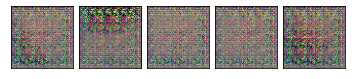

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.20869112345907423
Generator loss:     3.802511563272556
Saved checkpoint.


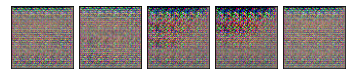

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
Discriminator loss: 1.1833266996675067
Generator loss:     3.9188694291728674
Saved checkpoint.


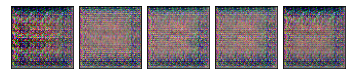

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
Discriminator loss: 1.454946047729916
Generator loss:     1.8177421783966468
Saved checkpoint.


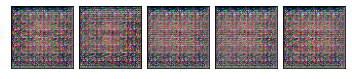

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
Discriminator loss: 0.5541606346766154
Generator loss:     2.3481883185243007
Saved checkpoint.


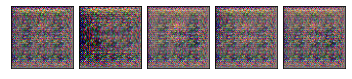

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 0.33502309852176243
Generator loss:     2.925685192036868
Saved checkpoint.


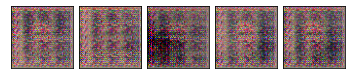

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.2932639304134581
Generator loss:     3.182499137140573
Saved checkpoint.


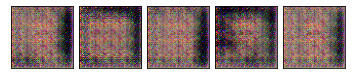

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: 1.9385191334618463
Generator loss:     1.9318964790488862
Saved checkpoint.


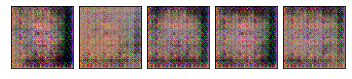

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
Discriminator loss: 0.5709889961613549
Generator loss:     1.8973210730227719
Saved checkpoint.


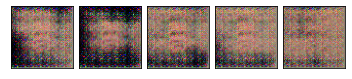

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.5939486655924056
Generator loss:     1.9974329841486176
Saved checkpoint.


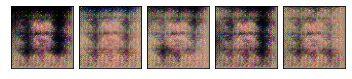

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
Discriminator loss: 2.2196604675716824
Generator loss:     1.7248540820637328
Saved checkpoint.


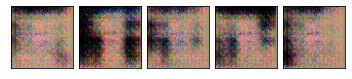

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 1.2885742452409532
Generator loss:     0.9019851551092629
Saved checkpoint.


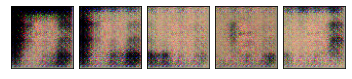

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
Discriminator loss: 1.3179288572735257
Generator loss:     0.8800016862572251
Saved checkpoint.


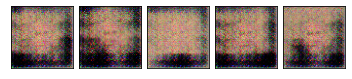

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
Discriminator loss: 1.2578446997536554
Generator loss:     0.9793757247714604
Saved checkpoint.


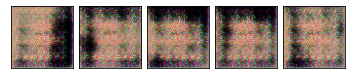

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
Discriminator loss: 1.1876733700434368
Generator loss:     1.0998752577705315
Saved checkpoint.


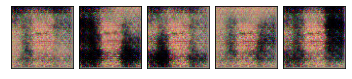

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 1.1905343797471788
Generator loss:     1.1581062202843586
Saved checkpoint.


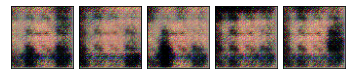

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
Discriminator loss: 1.0401086807250977
Generator loss:     1.4667187000241555
Saved checkpoint.


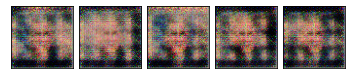

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
Discriminator loss: 0.9146718713972304
Generator loss:     1.6660918081850282
Saved checkpoint.


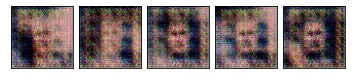

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.49it/s]
Discriminator loss: 0.754769331879086
Generator loss:     2.074078852000204
Saved checkpoint.


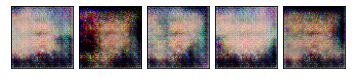

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
Discriminator loss: 1.0368426442146301
Generator loss:     2.0417744082037004
Saved checkpoint.


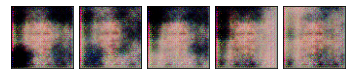

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
Discriminator loss: 0.9601898292700449
Generator loss:     1.8219123597885607
Saved checkpoint.


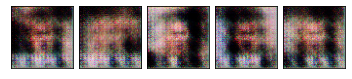

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.60it/s]
Discriminator loss: 1.7280883921517267
Generator loss:     1.2562557517349604
Saved checkpoint.


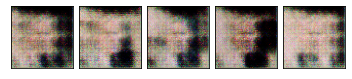

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
Discriminator loss: 1.3713169892628987
Generator loss:     0.7904086245400616
Saved checkpoint.


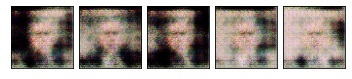

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
Discriminator loss: 1.299332406785753
Generator loss:     0.876789339030535
Saved checkpoint.


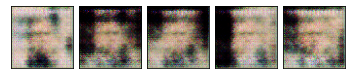

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.48it/s]
Discriminator loss: 1.1242864661746554
Generator loss:     0.9740854856349852
Saved checkpoint.


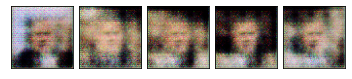

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
Discriminator loss: 1.272441612349616
Generator loss:     1.0253719152487477
Saved checkpoint.


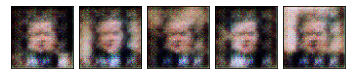

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 1.1118861304389105
Generator loss:     1.2000341702929458
Saved checkpoint.


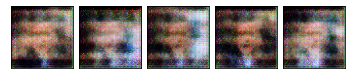

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
Discriminator loss: 1.0320802794562445
Generator loss:     1.361610585603567
Saved checkpoint.


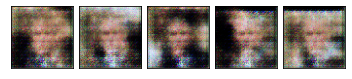

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.56it/s]
Discriminator loss: 1.0728268689579434
Generator loss:     1.337751429732416
Saved checkpoint.


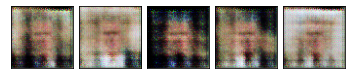

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
Discriminator loss: 1.2185356087154813
Generator loss:     1.3931759348774646
Saved checkpoint.


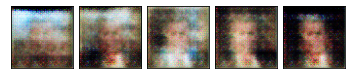

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
Discriminator loss: 1.2873818476994832
Generator loss:     1.2874863027373473
Saved checkpoint.


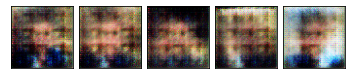

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
Discriminator loss: 1.0823679433928595
Generator loss:     1.3919867015696021
Saved checkpoint.


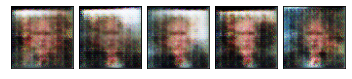

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.54it/s]
Discriminator loss: 1.2524709966447618
Generator loss:     1.2952169444536412
Saved checkpoint.


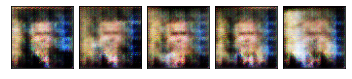

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
Discriminator loss: 1.1474670635329351
Generator loss:     1.4771550431834881
Saved checkpoint.


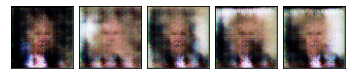

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.55it/s]
Discriminator loss: 1.0713017516665988
Generator loss:     1.376172147848804
Saved checkpoint.


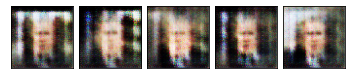

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
Discriminator loss: 1.050582038031684
Generator loss:     1.6771046044914928
Saved checkpoint.


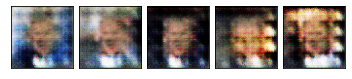

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
Discriminator loss: 1.1535275048679776
Generator loss:     1.4510829594953216
Saved checkpoint.


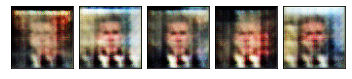

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
Discriminator loss: 1.1007914675606623
Generator loss:     1.5298355144230287
Saved checkpoint.


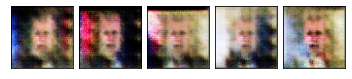

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.57it/s]
Discriminator loss: 1.2128584451145596
Generator loss:     1.5185802028560464
Saved checkpoint.


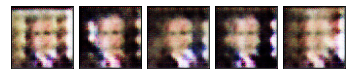

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
Discriminator loss: 1.0826439261436462
Generator loss:     1.4931890063799493
Saved checkpoint.


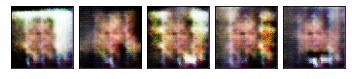

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
Discriminator loss: 1.207657469643487
Generator loss:     1.423986868944319
Saved checkpoint.


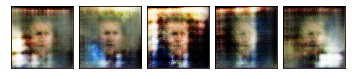

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
Discriminator loss: 1.0484066208203633
Generator loss:     1.467907656382352
Saved checkpoint.


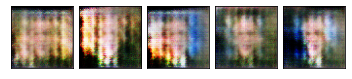

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 1.0272081626786127
Generator loss:     1.6451669477765343
Saved checkpoint.


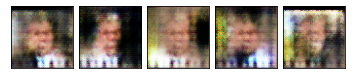

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 1.2644523249732122
Generator loss:     1.3271989800982873
Saved checkpoint.


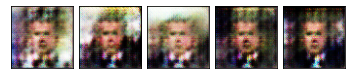

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 1.0455698900752597
Generator loss:     1.4393713326445576
Saved checkpoint.


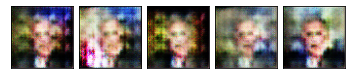

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
Discriminator loss: 1.1184677812788222
Generator loss:     1.470606574432007
Saved checkpoint.


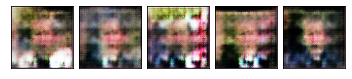

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
Discriminator loss: 0.8804165323575338
Generator loss:     1.840532359326718
Saved checkpoint.


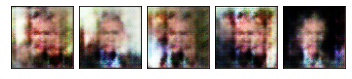

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
Discriminator loss: 1.1265120572514005
Generator loss:     1.6313362088742833
Saved checkpoint.


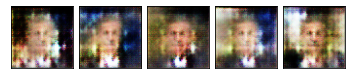

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 1.0164469679196675
Generator loss:     1.7202453787976109
Saved checkpoint.


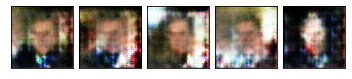

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
Discriminator loss: 1.2956036196814642
Generator loss:     1.301087245851508
Saved checkpoint.


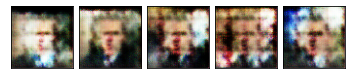

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
Discriminator loss: 1.1053889592488606
Generator loss:     1.4067638625191055
Saved checkpoint.


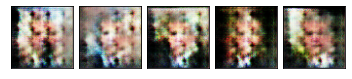

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
Discriminator loss: 0.8206767903433906
Generator loss:     1.7571417908744453
Saved checkpoint.


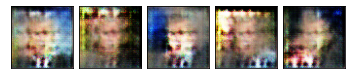

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.55it/s]
Discriminator loss: 0.9752699997689989
Generator loss:     1.9351108782429813
Saved checkpoint.


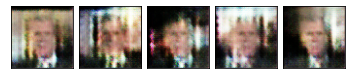

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 0.893125143316057
Generator loss:     1.7263721372936311
Saved checkpoint.


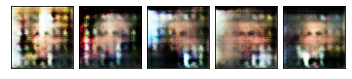

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
Discriminator loss: 0.9706869522730509
Generator loss:     1.9846979012371644
Saved checkpoint.


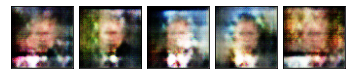

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 0.8789547284444174
Generator loss:     1.7782279146487545
Saved checkpoint.


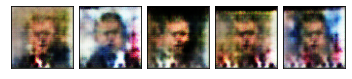

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.894318421681722
Generator loss:     2.0659589414631587
Saved checkpoint.


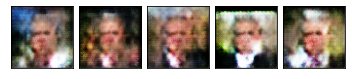

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
Discriminator loss: 1.1398729019694858
Generator loss:     1.6909628575092281
Saved checkpoint.


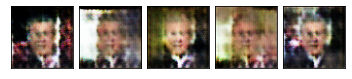

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
Discriminator loss: 0.8443058199352689
Generator loss:     1.7506736763323505
Saved checkpoint.


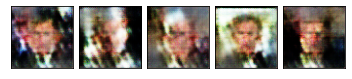

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
Discriminator loss: 1.396632883283827
Generator loss:     1.5339282589361953
Saved checkpoint.


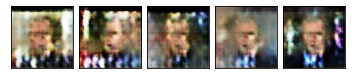

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 0.9793666402498881
Generator loss:     1.4866963098463613
Saved checkpoint.


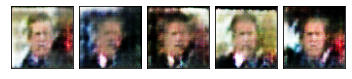

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
Discriminator loss: 1.1223905351426866
Generator loss:     1.5537536304342785
Saved checkpoint.


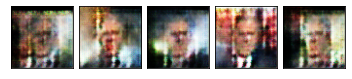

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 0.8487734927071465
Generator loss:     1.7061289353673534
Saved checkpoint.


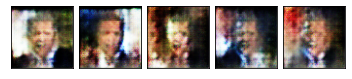

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
Discriminator loss: 0.953926338089837
Generator loss:     1.7112236143113357
Saved checkpoint.


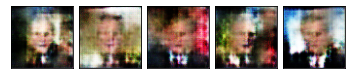

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.48it/s]
Discriminator loss: 0.9607504142655267
Generator loss:     1.7413457609781966
Saved checkpoint.


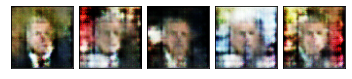

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 1.0773517555660672
Generator loss:     1.760578937893792
Saved checkpoint.


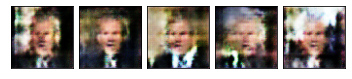

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.8456259104940627
Generator loss:     1.8676481255064357
Saved checkpoint.


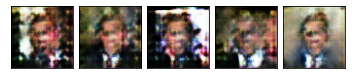

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
Discriminator loss: 1.0485787855254278
Generator loss:     1.8649244921428922
Saved checkpoint.


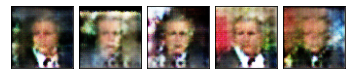

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 0.9805578258302476
Generator loss:     1.7738709561822594
Saved checkpoint.


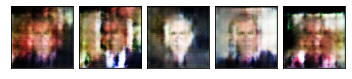

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
Discriminator loss: 0.9616600275039673
Generator loss:     1.852264506260165
Saved checkpoint.


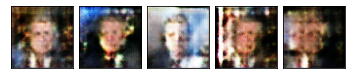

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
Discriminator loss: 0.8351390295558505
Generator loss:     1.7794015436620139
Saved checkpoint.


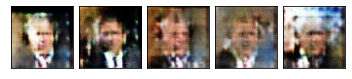

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.39it/s]
Discriminator loss: 1.5880283978250291
Generator loss:     1.8377247931209635
Saved checkpoint.


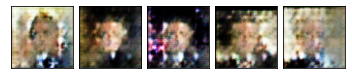

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
Discriminator loss: 0.9871758619944254
Generator loss:     1.2383339198649568
Saved checkpoint.


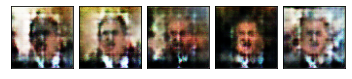

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
Discriminator loss: 0.8688813050587972
Generator loss:     1.6044305566897412
Saved checkpoint.


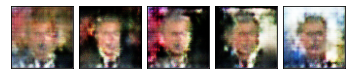

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
Discriminator loss: 0.9664776590135362
Generator loss:     1.7095545628078876
Saved checkpoint.


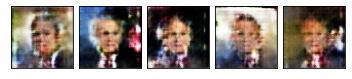

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
Discriminator loss: 0.805204815334744
Generator loss:     1.8495452051766348
Saved checkpoint.


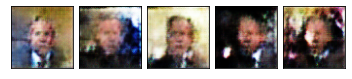

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
Discriminator loss: 1.1915048758188884
Generator loss:     1.7965935353899072
Saved checkpoint.


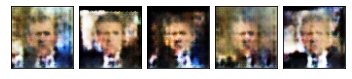

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 0.8825813863012526
Generator loss:     1.7306099921524907
Saved checkpoint.


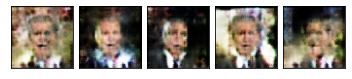

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
Discriminator loss: 1.0153435601128473
Generator loss:     1.8975337986595795
Saved checkpoint.


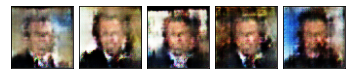

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
Discriminator loss: 0.8467579086621603
Generator loss:     1.7605067325182817
Saved checkpoint.


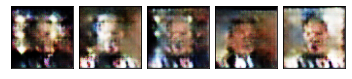

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.55it/s]
Discriminator loss: 0.8718014359474182
Generator loss:     1.8678373544592408
Saved checkpoint.


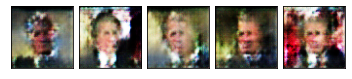

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.24it/s]
Discriminator loss: 0.8232070538732741
Generator loss:     1.952000904453997
Saved checkpoint.


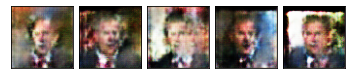

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.13it/s]
Discriminator loss: 0.7111407981978523
Generator loss:     1.9569697183951185
Saved checkpoint.


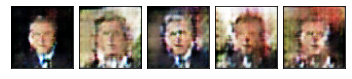

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
Discriminator loss: 1.0078951451513503
Generator loss:     1.8911540122632102
Saved checkpoint.


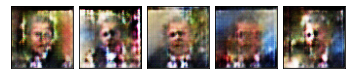

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
Discriminator loss: 0.7675438721974691
Generator loss:     1.9634980596035803
Saved checkpoint.


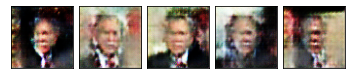

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
Discriminator loss: 0.6952007479137845
Generator loss:     2.0356030609210864
Saved checkpoint.


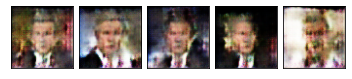

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
Discriminator loss: 0.9991493688689338
Generator loss:     2.226212258312611
Saved checkpoint.


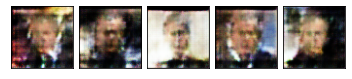

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
Discriminator loss: 0.7718498375680711
Generator loss:     2.124769261033052
Saved checkpoint.


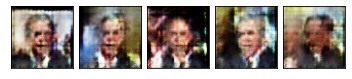

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
Discriminator loss: 1.3256221612294514
Generator loss:     1.7220237503272966
Saved checkpoint.


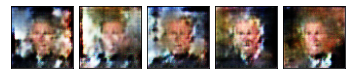

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
Discriminator loss: 0.7152197625901964
Generator loss:     1.7438667840840545
Saved checkpoint.


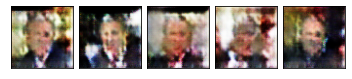

In [129]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


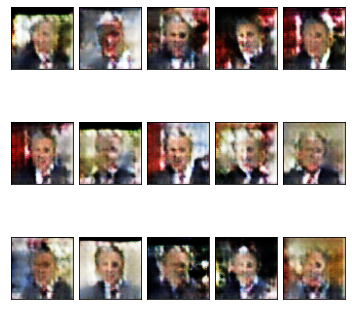

In [130]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [131]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [132]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [133]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [134]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

